In [1]:
import os
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import cv2
import sys
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import imageio
from random import shuffle
import random
import shutil

from tqdm.notebook import trange, tqdm
import itertools
import pandas as pd
import seaborn as sns
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
from keras.layers import Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D # to add convolutional layers
from keras.layers.convolutional import MaxPooling2D # to add pooling layers
from keras.layers import Flatten # to flatten data for fully connected layers
from keras.layers import Dropout # to avoid overfitting
from keras.layers import Activation

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [4]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['val_loss'][-1]
    acc = history.history['val_acc'][-1]
    plt.title('Validation Loss: %.3f, Validation Accuracy: %.3f' % (loss, acc))

In [5]:
train_categories = pd.read_csv('train.csv')
train_categories['filename'] = train_categories['filename'].apply(lambda x: int(x.split('.')[0]))
train_images = train_categories.filename.values.tolist()
location = 'C:\\Users\\ak19919\\Downloads\\Github\\Analytics-Vidya\\MNIST\\images'
trainLabels = {}
f = open("train.csv", "r")
train_digits = f.read()
train_digits = train_digits.split('\n')
for i in range(len(train_digits) - 1):
    train_digits[i] = train_digits[i].split(',')
    trainLabels[train_digits[i][0].split('.')[0]] = train_digits[i][1]
del trainLabels['filename']

test_digits = pd.read_csv('test.csv')
testImages = test_digits.filename.values.tolist()

In [6]:
Digits = trainLabels.values()
trainSet = set(Digits)
itr_set = {}
for i in trainSet:
    itr_set[i] = 0

In [7]:
if not os.path.exists(location + str('\\train_labelled')):
    os.makedirs(location + str('\\train_labelled'))
    os.makedirs(location + str('\\test_labelled'))
    
    # Combine labels and images and move to labelled train folder
    for img in tqdm(os.listdir(location + '\\train')):
        if not int(img.split('.')[0]) in train_images:
            continue
        imgName = img.split('.')[0]
        label = trainLabels[str(imgName)]
        itr_set[label] += 1
        path = os.path.join(location + '\\train\\', img)
        saveName = location + '\\train_labelled\\' + label + '-' + str(itr_set[label]) + '.png'
        image_data = np.array(Image.open(path))
        imageio.imwrite(saveName, image_data)
        
    # Move 20% of labelled data to validation folder for testing
    validation_data = os.listdir(location + '\\train_labelled')
    random.Random(2).shuffle(validation_data)
    for i in itr_set:
        itr_set[i] = int(itr_set[i]*0.2)
    for i in tqdm(itr_set):
        for j in validation_data:
            if j.split('-')[0] == i:
                if itr_set[i] > 0:
                    shutil.move(location + '\\train_labelled\\' + str(j), location + str('\\test_labelled'))
                    itr_set[i] -= 1

# Move unlabelled data for classification to test folder
if not os.path.exists(location + str('\\test_images')):
    os.makedirs(location + str('\\test_images'))
    for image in tqdm(testImages):
        shutil.move(location + '\\test\\' + image, location + str('\\test_images'))

In [8]:
def label_img(name):
    word_label = name.split('-')[0]
    if word_label == '0' : return np.array([1,0,0,0,0,0,0,0,0,0])
    elif word_label == '1' : return np.array([0,1,0,0,0,0,0,0,0,0])
    elif word_label == '2' : return np.array([0,0,1,0,0,0,0,0,0,0])
    elif word_label == '3' : return np.array([0,0,0,1,0,0,0,0,0,0])
    elif word_label == '4' : return np.array([0,0,0,0,1,0,0,0,0,0])
    elif word_label == '5' : return np.array([0,0,0,0,0,1,0,0,0,0])
    elif word_label == '6' : return np.array([0,0,0,0,0,0,1,0,0,0])
    elif word_label == '7' : return np.array([0,0,0,0,0,0,0,1,0,0])
    elif word_label == '8' : return np.array([0,0,0,0,0,0,0,0,1,0])
    elif word_label == '9' : return np.array([0,0,0,0,0,0,0,0,0,1])

In [9]:
def get_size_statistics(DIR):
    heights = []
    widths = []
    for img in tqdm(os.listdir(DIR)): 
        path = os.path.join(DIR, img)
        data = np.array(Image.open(path)) #PIL Image library
        heights.append(data.shape[0])
        widths.append(data.shape[1])
    avg_height = sum(heights) / len(heights)
    avg_width = sum(widths) / len(widths)
    print("Average Height: " + str(avg_height))
    print("Max Height: " + str(max(heights)))
    print("Min Height: " + str(min(heights)))
    print("Average Width: " + str(avg_width))
    print("Max Width: " + str(max(widths)))
    print("Min Width: " + str(min(widths)))

In [10]:
get_size_statistics(location + '\\train_labelled')


Average Height: 28.0
Max Height: 28
Min Height: 28
Average Width: 28.0
Max Width: 28
Min Width: 28


In [11]:
IMG_SIZE = 56
def load_training_data(DIR):
    train_data = []
    for img in tqdm(os.listdir(DIR)):
        label = label_img(img)
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        train_data.append([np.array(img), label])
    shuffle(train_data)
    return train_data

def load_validation_data(DIR):
    val_data = []
    for img in tqdm(os.listdir(DIR)):
        label = label_img(img)
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        val_data.append([np.array(img), label])
    shuffle(val_data)
    return val_data

def load_testing_data(DIR):
    test_data = []
    for Img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, Img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        test_data.append([np.array(img), Img])
    return test_data

In [12]:
train_data = load_training_data(location + '\\train_labelled')
val_data = load_validation_data(location + '\\test_labelled')
X_train = np.array([i[0] for i in train_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_train = X_train / 255 # normalize training data
y_train = np.array([i[1] for i in train_data])
y_train = y_train / 255 # normalize training data
X_test = np.array([i[0] for i in val_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test / 255 # normalize test data
y_test = np.array([i[1] for i in val_data])
y_test = y_test / 255 # normalize training data

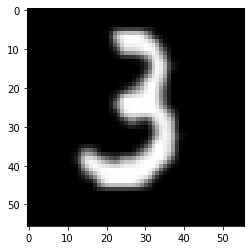

In [13]:
plt.imshow(train_data[1247][0], cmap = 'gist_gray')

In [14]:
def convolutional_model():
    ADAMAX = optimizers.Adamax(lr = 0.002, beta_1 = 0.9, beta_2 = 0.999)
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), activation = 'relu', input_shape = (IMG_SIZE, IMG_SIZE, 1)))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (2, 2), activation = 'relu'))
    model.add(Conv2D(256, (2, 2), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    model.add(BatchNormalization(axis = -1))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation = 'relu'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation = 'softmax'))
    
    # Compile model
    model.compile(optimizer = ADAMAX, loss = 'categorical_crossentropy',  metrics = ['accuracy'])
    return model

In [15]:
gen = ImageDataGenerator(rotation_range = 12, width_shift_range = 0.2, shear_range = 0.2,
                         height_shift_range = 0.2, zoom_range = 0.2, fill_mode = 'nearest', horizontal_flip = False,
                         vertical_flip = False, featurewise_center = False,
                         samplewise_center = False, featurewise_std_normalization = False,
                         samplewise_std_normalization = False)
test_gen = ImageDataGenerator()

# Create batches to  train models faster
train_generator = gen.flow(X_train, y_train, batch_size = 32)
test_generator = test_gen.flow(X_test, y_test, batch_size = 32)

In [16]:
# Use annelar to gradually decrese the learning rate to improve generalization

reduce_lr = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.4, min_lr = 0.00002,
                                            mode = 'auto', cooldown = 0)

In [17]:
# build the model
model = convolutional_model()
epochs = 70
# fit the model

#history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, batch_size = 200, verbose = 2)

history = model.fit_generator(train_generator, steps_per_epoch = 1225, epochs = epochs, 
                              validation_data = test_generator, validation_steps = 1225, verbose = 1,
                              callbacks=[reduce_lr])

# evaluate the model
scores = model.evaluate(X_test, y_test, verbose = 0)

Epoch 1/70
1225/1225 [==============================] - 659s 538ms/step - loss: 0.0025 - acc: 0.7948 - val_loss: 6.1719e-04 - val_acc: 0.9560
Epoch 2/70
1225/1225 [==============================] - 657s 536ms/step - loss: 0.0010 - acc: 0.9183 - val_loss: 3.3433e-04 - val_acc: 0.9761
Epoch 3/70
1225/1225 [==============================] - 659s 538ms/step - loss: 7.6514e-04 - acc: 0.9405 - val_loss: 2.2962e-04 - val_acc: 0.9820
Epoch 4/70
1225/1225 [==============================] - 655s 535ms/step - loss: 6.6272e-04 - acc: 0.9485 - val_loss: 2.0535e-04 - val_acc: 0.9852
Epoch 5/70
1225/1225 [==============================] - 663s 541ms/step - loss: 5.7069e-04 - acc: 0.9551 - val_loss: 2.4505e-04 - val_acc: 0.9800
Epoch 6/70
1225/1225 [==============================] - 659s 538ms/step - loss: 5.0363e-04 - acc: 0.9618 - val_loss: 1.3643e-04 - val_acc: 0.9897
Epoch 7/70
1225/1225 [==============================] - 657s 536ms/step - loss: 4.7150e-04 - acc: 0.9636 - val_loss: 1.5196e-04 - va

Accuracy: 0.9943848902501277 
 Error: 0.5615109749872289


<Figure size 576x432 with 0 Axes>

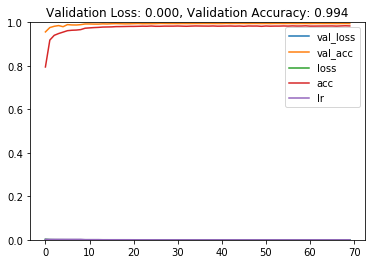

In [18]:
print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))
plot_loss_accuracy(history)

Confusion matrix, without normalization
[[ 964    0    0    0    0    0    2    0    0    0]
 [   0 1095    0    0    0    0    1    6    0    0]
 [   0    1  970    4    1    0    0    0    0    2]
 [   0    0    0  996    0    2    0    1    0    0]
 [   0    1    0    0  952    0    0    0    0    2]
 [   1    0    0    3    0  875    3    0    1    0]
 [   1    0    0    0    0    0  959    0    2    0]
 [   0    2    5    0    1    0    0 1013    0    0]
 [   1    0    0    0    0    1    0    0  952    1]
 [   0    1    0    0    6    1    0    2    0  964]]


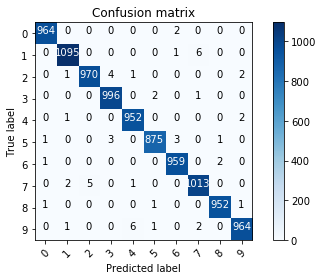

In [19]:
y_pred = np.argmax(model.predict(X_test), axis = 1)
Y_true = np.argmax(y_test, axis = 1)
cm = confusion_matrix(Y_true, y_pred)
plot_confusion_matrix(cm, classes = range(10))

In [20]:
test_data = load_testing_data(location + '\\test_images')
test = np.array([i[0] for i in test_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_labels = np.array([i[1] for i in test_data])
test = test / 255 # normalize test data
Y_pred = np.round(model.predict(test))
Y_pred = np.argmax(Y_pred, axis = 1)
Y_pred = pd.Series(Y_pred, name = "label")

In [21]:
submission_df = pd.DataFrame({
                  "filename": pd.Series(test_labels),
                  "label": pd.Series(Y_pred)})
submission_df.to_csv('submission_3_36x36.csv', index = False)

In [22]:
LR = 0.002
model_name = 'classify_apparels-{}-{}.model'.format(LR, 'CCMBD_CMDB_CCMBD_FDBDADD_conv_v5_36x36')
model.save(model_name)